In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple, Union

from cpsplines.fittings.fit_cpsplines import CPsplines
from cpsplines.graphics.plot_surfaces import SurfacesDisplay
from cpsplines.psplines.bspline_basis import BsplineBasis

from simulations import simulated_example

In [3]:
SAVEFIG = True

In [4]:
def plot_curve_knots(
    bspline_1: BsplineBasis,
    bspline_2: BsplineBasis,
    knot_plane: Union[int, float] = -3,
    curve_step: Union[int, float] = 0.02,
    figsize: Tuple[Union[int, float], Union[int, float]] = (12, 10),
) -> Axes:
    """Plots a smooth surface (in grey), together with the curves (in red) on
    which the constraints are to be imposed, and the knot mesh (in green) which
    defines the bivariate B-spline basis.

    Parameters
    ----------
    bspline_1 : BsplineBasis
        The B-spline basis object along the first direction.
    bspline_2 : BsplineBasis
        The B-spline basis object along the first direction.
    knot_plane : Union[int, float], optional
        The independent term of the plane in which the knots are plotted, by
        default -3.
    curve_step : Union[int, float], optional
        The separation of the curves in the surface to appreciate them better,
        by default 0.02.
    figsize : Tuple[Union[int, float], Union[int, float]], optional
        The size of the figure, by default (12, 10).

    Returns
    -------
    Axes
        The axis used in the plot. 
    """
    def _surface_curve_knots(x_1: np.ndarray, x_2: np.ndarray) -> np.ndarray:
        """The surface used in the plot, which is cos(x_1)*x_2.

        Parameters
        ----------
        x_1 : np.ndarray
            The coordinates along the X_1-axis.
        x_2 : np.ndarray
            The coordinates along the X_2-axis.

        Returns
        -------
        np.ndarray
            The points in the surface to be plotted. 
        """
        return np.outer(np.cos(x_1), x_2)

    _, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection="3d"))
    Z, X = np.meshgrid(bspline_1.xsample, bspline_2.xsample)
    Y = _surface_curve_knots(x_1=bspline_1.xsample, x_2=bspline_2.xsample)
    # Graph the points of the surface using a wireframe plot
    _ = ax.plot_wireframe(Z, X, Y.T, rstride=2, cstride=2, color="grey")
    # Plot the knot mesh and the curves in the surface along the X_1-axis
    for kn in bspline_1.knots[bspline_1.deg : -bspline_1.deg]:
        _ = ax.plot(
            np.repeat(kn, len(bspline_2.xsample)),
            bspline_2.xsample,
            np.repeat(knot_plane, len(bspline_2.xsample)),
            color="green",
            linestyle="--",
            alpha=1,
        )
        _ = ax.plot(
            np.repeat(kn, len(bspline_2.xsample)),
            bspline_2.xsample,
            Y[np.abs(bspline_1.xsample - kn).argmin(), :] + curve_step,
            color="red",
            linestyle="--",
            alpha=1,
        )
    # Plot the knot mesh and the curves in the surface along the X_2-axis
    for kn in bspline_2.knots[bspline_2.deg : -bspline_2.deg]:
        _ = ax.plot(
            bspline_1.xsample,
            np.repeat(kn, len(bspline_1.xsample)),
            np.repeat(knot_plane, len(bspline_1.xsample)),
            color="green",
            linestyle="--",
            alpha=1,
        )
        _ = ax.plot(
            bspline_1.xsample,
            np.repeat(kn, len(bspline_1.xsample)),
            Y[:, np.abs(bspline_2.xsample - kn).argmin()] + curve_step,
            color="red",
            linestyle="--",
            alpha=1,
        )

    return ax

FIG 1. A smooth surface (in grey), together with the curves (in red) on which
the constraints are to be imposed, and the knot mesh (in green) which defines
the bivariate B-spline basis.

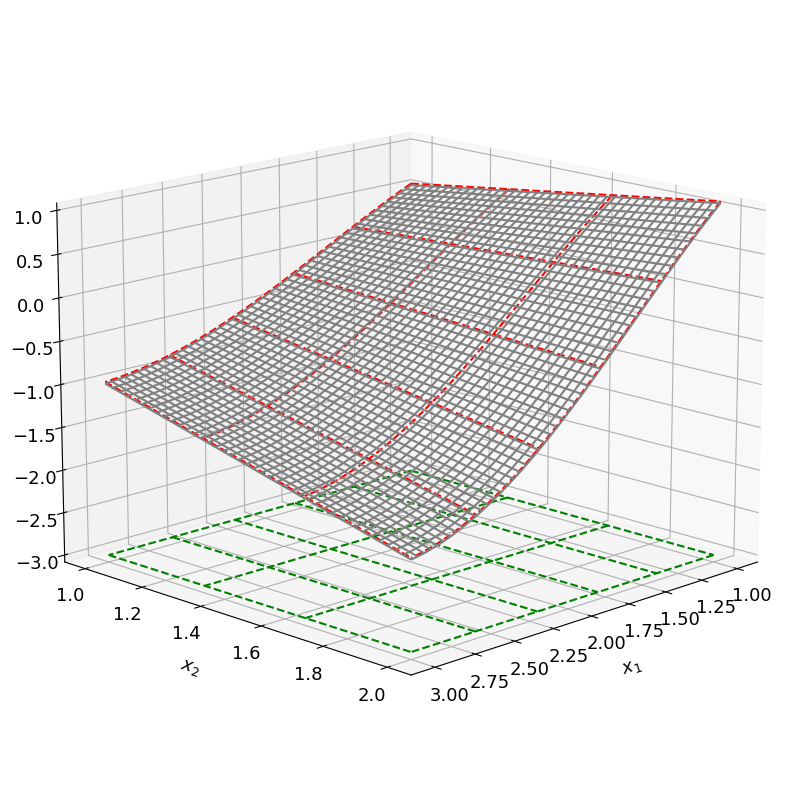

In [5]:
matplotlib.rc('font', **{'size' : 13})
# Generate the B-spline bases 
bspline_1 = BsplineBasis(deg=3, xsample=np.linspace(1, 3, 101), n_int=5)
_ = bspline_1.get_matrix_B()
bspline_2 = BsplineBasis(deg=3, xsample=np.linspace(1, 2, 81), n_int=3)
_ = bspline_2.get_matrix_B()

ax = plot_curve_knots(bspline_1=bspline_1, bspline_2=bspline_2)
_ = ax.set_xlabel("$x_1$", labelpad=10)
_ = ax.set_ylabel("$x_2$", labelpad=10)
_ = ax.view_init(15, 45)
_ = ax.set_zlim(-3, 1)
if SAVEFIG:
    _ = ax.get_figure().savefig("../img/curvas_nodo.pdf", bbox_inches="tight")

FIG 2. Perspective and contour plots of the surface defined by the function in
`simulated_example`.


2023-05-02 09:35:09,732 | INFO: Data is rearranged into a grid.


[Solve the problem with smoothing parameters (1.0, 1.0): ] Elapsed time (s): 0.059379


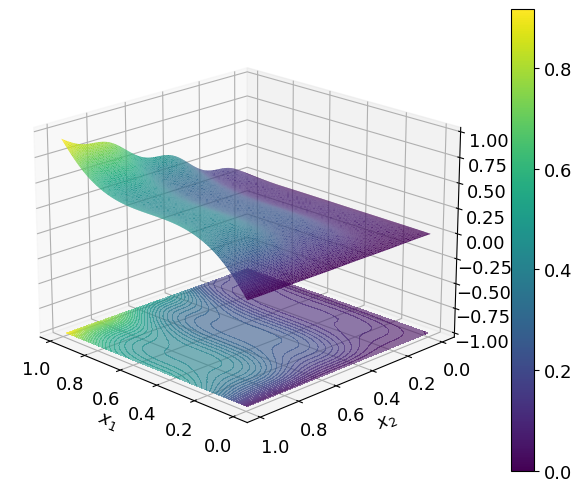

In [6]:
matplotlib.rc('font', **{'size' : 13})
data = simulated_example(x_1=(0, 1), x_2=(0, 1), n=100, grid=True)

cps = CPsplines(deg=(3, 3), ord_d=(2, 2), n_int=(20, 20))
cps.fit(data=data, y_col="y")

X, Y = np.meshgrid(np.linspace(data.iloc[:, 0].min(), data.iloc[:, 0].max()),
                   np.linspace(data.iloc[:, 1].min(), data.iloc[:, 1].max()))
Z = cps.predict(pd.DataFrame({"x0": X.flatten(), "y": Y.flatten()})).reshape((50,50))

surface1 = SurfacesDisplay.from_estimator(cps, 
                                          orientation=(20, 135), 
                                          figsize=(10, 6), 
                                          contour_plot=False,
                                          **{"cmap": "viridis"}
                                          )
_ = surface1.ax_.set_xlabel('$x_1$')
_ = surface1.ax_.set_ylabel('$x_2$')
_ = surface1.ax_.contourf(X, Y, Z, levels=50, cmap="viridis", offset=-1, alpha=0.6)
_ = surface1.ax_.set_zlim((-1, 1))
if SAVEFIG:
    _ = surface1.ax_.get_figure().savefig("../img/simulated_example.pdf", bbox_inches="tight")

TABLE 1. Mean ($\mu_{\boldsymbol{\cdot}}$) and standard deviation
($\sigma_{\boldsymbol{\cdot}}$) over $100$ replicates of the MAE and MSE,
between the theoretical function in FIG 2 and the estimated values,
and computational times, for each level of noise $\sigma$ and data structure
(gridded and scattered).

In [7]:
df = pd.read_parquet("../data/simulation_results.parquet").groupby(["level_1", "level_2"]).describe().stack(1)
df.columns = df.columns.str.split("_",expand=True)
df = df.unstack(0).stack(0).reorder_levels([1, 0], axis=1).sort_index(axis=1, ascending=False).reorder_levels([0, 2, 1]).sort_index()
df[df.index.isin(['mean', 'std'], level=2)].rename_axis(index={'level_2': 'sigma'}, columns={"level_1": "Gridded"})

Gridded                  True                                      \
                 Unconstrained         Pya    Navarro       Meyer   
sigma                                                               
0.05  MAE   mean      0.009077    0.006991   0.007213    0.007223   
            std       0.000589    0.003194   0.000599    0.000665   
      MSE   mean      0.000137    0.000103   0.000092    0.000091   
            std       0.000016    0.000166   0.000013    0.000015   
      Times mean      1.936960  398.587685   6.278571  688.648056   
            std       0.604622  268.913654   0.971714  208.391759   
0.10  MAE   mean      0.013967    0.012168   0.011883    0.012458   
            std       0.001214    0.002561   0.001116    0.001185   
      MSE   mean      0.000319    0.000250   0.000233    0.000257   
            std       0.000049    0.000089   0.000037    0.000045   
      Times mean      6.231789  528.575171  10.817561  356.608602   
            std       0.871235  304.702853   1.156345   75.678972   
0.25  MAE   mean      0.026939    0.024170   0.022757    0.025956   
            std       0.002866    0.005240   0.002678    0.003306   
      MSE   mean      0.001213    0.001023   0.000874    0.001166   
            std       0.000243    0.000552   0.000188    0.000302   
      Times mean      9.076987  325.635800  13.383947  711.601220   
            std       2.812290  228.315517   3.022700  884.236521   
0.50  MAE   mean      0.043392    0.035649   0.035871    0.043378   
            std       0.005972    0.005931   0.005502    0.005651   
      MSE   mean      0.003180    0.002203   0.002212    0.003352   
            std       0.000826    0.000723   0.000616    0.000859   
      Times mean     10.594910  132.320234  15.017557  498.581169   
            std       6.960762  113.166797   8.337969  398.340158   

Gridded                  False                                      
                 Unconstrained         Pya    Navarro        Meyer  
sigma                                                               
0.05  MAE   mean      0.009300    0.007019   0.007522     0.007697  
            std       0.000619    0.002049   0.000657     0.000776  
      MSE   mean      0.000139    0.000090   0.000095     0.000099  
            std       0.000018    0.000064   0.000016     0.000020  
      Times mean      6.565400  329.987163  10.304425  2741.248554  
            std       1.596526  168.204132   1.950479   895.005573  
0.10  MAE   mean      0.014379    0.013437   0.011937     0.012657  
            std       0.001285    0.002934   0.001294     0.001532  
      MSE   mean      0.000336    0.000304   0.000239     0.000272  
            std       0.000058    0.000114   0.000047     0.000065  
      Times mean     20.502314  375.342444  24.372095  2821.501665  
            std       3.014133  316.605900   3.174781   626.715801  
0.25  MAE   mean      0.027790    0.023529   0.023046     0.025654  
            std       0.003177    0.004603   0.002564     0.003241  
      MSE   mean      0.001269    0.000948   0.000888     0.001123  
            std       0.000287    0.000421   0.000193     0.000293  
      Times mean     33.381228  364.397112  37.346401  3250.334311  
            std       5.247409  422.965643   5.377894   680.594866  
0.50  MAE   mean      0.042976    0.035876   0.034940     0.043170  
            std       0.006027    0.008872   0.005331     0.007071  
      MSE   mean      0.003029    0.002271   0.002071     0.003335  
            std       0.000823    0.001036   0.000625     0.001164  
      Times mean     41.004637  199.561237  44.953697  3814.759865  
            std       8.409724  325.701865   8.345731  4343.274052

TABLE 2. Mean ($\mu_{\boldsymbol{\cdot}}$) and standard deviation
($\sigma_{\boldsymbol{\cdot}}$) over the $10$ folds of the MAE and MSE, between
the observed and the estimated values in the $\texttt{hschool}$ data set, and
the computational times. 

In [8]:
hschool = pd.read_parquet("../data/hschool_results.parquet")
hschool.describe().loc[["mean", "std"], :].stack(0).unstack(0)

MAE                  MSE                   Times  \
                   mean       std       mean        std         mean   
Meyer          5.322262  1.050764  54.833973  30.795975  1140.064941   
Navarro        4.933749  1.141808  47.421069  29.904855    37.768162   
Pya            4.967988  1.117949  48.086311  30.795486    42.617271   
Unconstrained  5.087281  1.257752  51.641464  31.019798    16.648492   

                           
                      std  
Meyer          804.944031  
Navarro         13.147448  
Pya             36.550026  
Unconstrained    6.687837

FIG 3. Contour plots of the surface obtained in one of the folds of the data set
for each of the methodologies tested. The regions where no data is gathered are
left uncoloured.

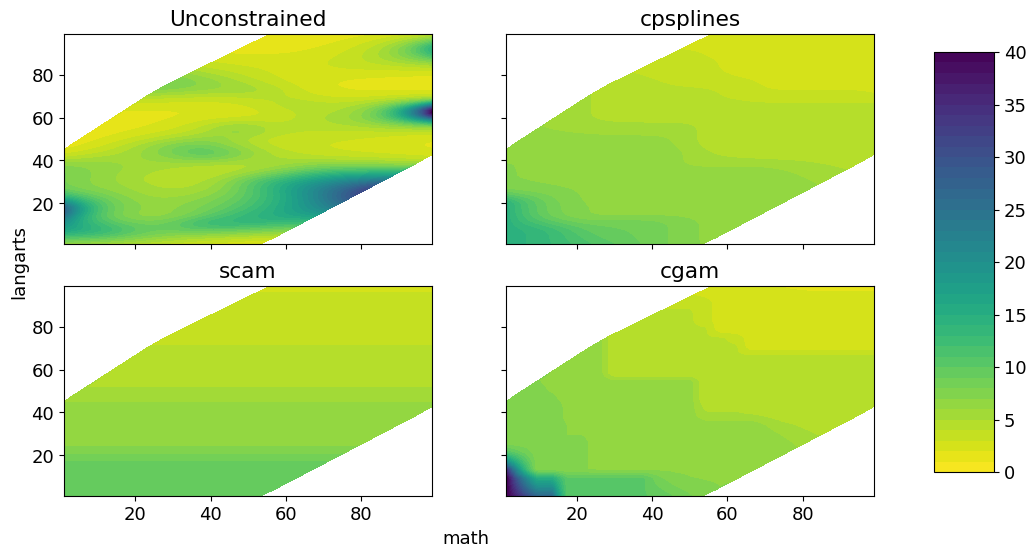

In [9]:
hschool_fold = pd.read_csv("../data/hschool_fold_pred.csv")
cols_pred = ["Unconstrained", "cpsplines", "scam", "cgam"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True, sharey=True)
for ax, col in zip(axes.flat, cols_pred):
    im = ax.tricontourf(*hschool_fold[["math", "langarts", col]].to_numpy().T,
                        cmap="viridis_r",
                        levels=np.linspace(0, 40, 41))
    _ = ax.set_title(col)

_ = fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
_ = fig.colorbar(im, cax=cbar_ax)
_ = fig.text(0.46, 0.03, 'math', ha='center')
_ = fig.text(0.08, 0.5, 'langarts', va='center', rotation='vertical')
if SAVEFIG:
    _ = fig.savefig("../img/hschool.pdf", bbox_inches="tight")

TABLE 4. Mean ($\mu_{\boldsymbol{\cdot}}$) and standard deviation
($\sigma_{\boldsymbol{\cdot}}$) over the 10 folds of the accuracy (ACC) and the
F1-score between the observed and the predicted outcome in the $\texttt{pima}$
data set, and the computational times.

In [10]:
pima = pd.read_parquet("../data/pima_results.parquet")
pima = pima.loc[:, pima.columns.isin(["Times", "Accuracy", "F1-score"], level=2)]
pima.describe().loc[["mean", "std"], :].stack([0, 1]).unstack(0)

Accuracy            F1-score                Times  \
                               mean       std      mean       std       mean   
Additive    Navarro        0.591734  0.096025  0.688263  0.053828   0.878693   
            Pya            0.600307  0.111097  0.689579  0.056800   1.710144   
            Unconstrained  0.585754  0.087441  0.688228  0.049871   0.686223   
Interaction Navarro        0.617933  0.084056  0.696193  0.064214  81.364111   
            Pya            0.584469  0.101871  0.681684  0.056202  36.864384   
            Unconstrained  0.573284  0.116028  0.682877  0.056672  72.580936   

                                      
                                 std  
Additive    Navarro         0.079902  
            Pya             2.622262  
            Unconstrained   0.062410  
Interaction Navarro        62.030307  
            Pya            25.703279  
            Unconstrained  64.605929